In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
import pickle

# justification of the dataset choice

I chose this dataset for its number of data (around 50_000 rows) and for the fact that it was very clean (as we were supposed to spend 1h exploring & modelling, I figured no time for cleaning a dirty dataset full of Nan and outliers).

The dataset is usually used as a regression task to try and predict the price of the diamonds but it can also be used as a multiclass dataset if trying to predict the 'color', 'cut' or 'clarity' features.
Here I will predict the cut feature of the diamond which range from fair to ideal in our dataset.

The cut of the diamond is how it was cutted, and ranges from fair to ideal.

### Features

- price: price in US dollars (326--18,823 in $)
- carat: weight of the diamond (0.2--5.01) - 200mg = 1 carat
- cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color: diamond colour, from J (worst) to D (best)
- clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- x: length in mm (0--10.74) 
- y: width in mm (0--58.9)
- z: depth in mm (0--31.8)
- depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table: width of top of diamond relative to widest point (43--95)

Lets try to predict one of the following: 
- cut of the diamond

In [2]:
df = pd.read_csv('diams/diamonds.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [4]:
# Separate into model development and production

# timestamp it
from datetime import datetime
df['Timestamp'] = pd.date_range(start='1/1/1960', periods=df.shape[0]).to_pydatetime().tolist()

In [5]:
# separate with time stamp

df_development = df.loc[:21576] # 40% of data to train
df_production = df.loc[21576:]

df_production.reset_index(drop=True, inplace=True)
df_production.to_csv("dataset_production.csv", encoding = 'utf-8', index=False)

del df
del df_production

# Part 1. Model development

In [6]:
df = df_development

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21577 entries, 0 to 21576
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  21577 non-null  int64         
 1   carat       21577 non-null  float64       
 2   cut         21577 non-null  object        
 3   color       21577 non-null  object        
 4   clarity     21577 non-null  object        
 5   depth       21577 non-null  float64       
 6   table       21577 non-null  float64       
 7   price       21577 non-null  int64         
 8   x           21577 non-null  float64       
 9   y           21577 non-null  float64       
 10  z           21577 non-null  float64       
 11  Timestamp   21577 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(2), object(3)
memory usage: 2.0+ MB


In [8]:
# Unnamed: 0 is just the index, lets drop it
df.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,Timestamp
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,1960-01-01
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,1960-01-02
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,1960-01-03
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,1960-01-04
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,1960-01-05


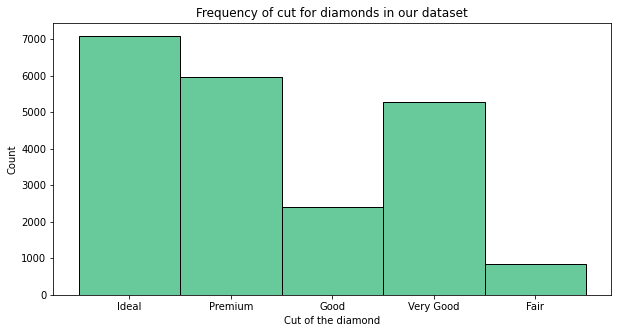

In [10]:
# lets plot the new target 
palette = sns.color_palette('viridis', 5)

fig = plt.subplots(figsize=(10,5))

sns.histplot(df.cut, bins=19, color=palette[3])
plt.title('Frequency of cut for diamonds in our dataset')
plt.xlabel('Cut of the diamond');
plt.show();

In [11]:
# Lets replace the categorical values that are in fact ordinals 

# I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)
df['clarity'].replace({'I1':1, 'SI2':2, 'SI1':3, 'VS2':4, 'VS1':5, 'VVS2':6, 'VVS1':7, 'IF':8}, inplace=True)

# color scale J (worst) to D (best)
df['color'].replace({'J':1, 'I':2, 'H':3, 'G':4, 'F':5, 'E':6, 'D':7}, inplace=True)

# cut: Fair, Good, Very Good, Premium, Ideal
df['cut'].replace({'Fair':1, 'Good':2, 'Very Good':3, 'Premium':4, 'Ideal':5}, inplace=True)

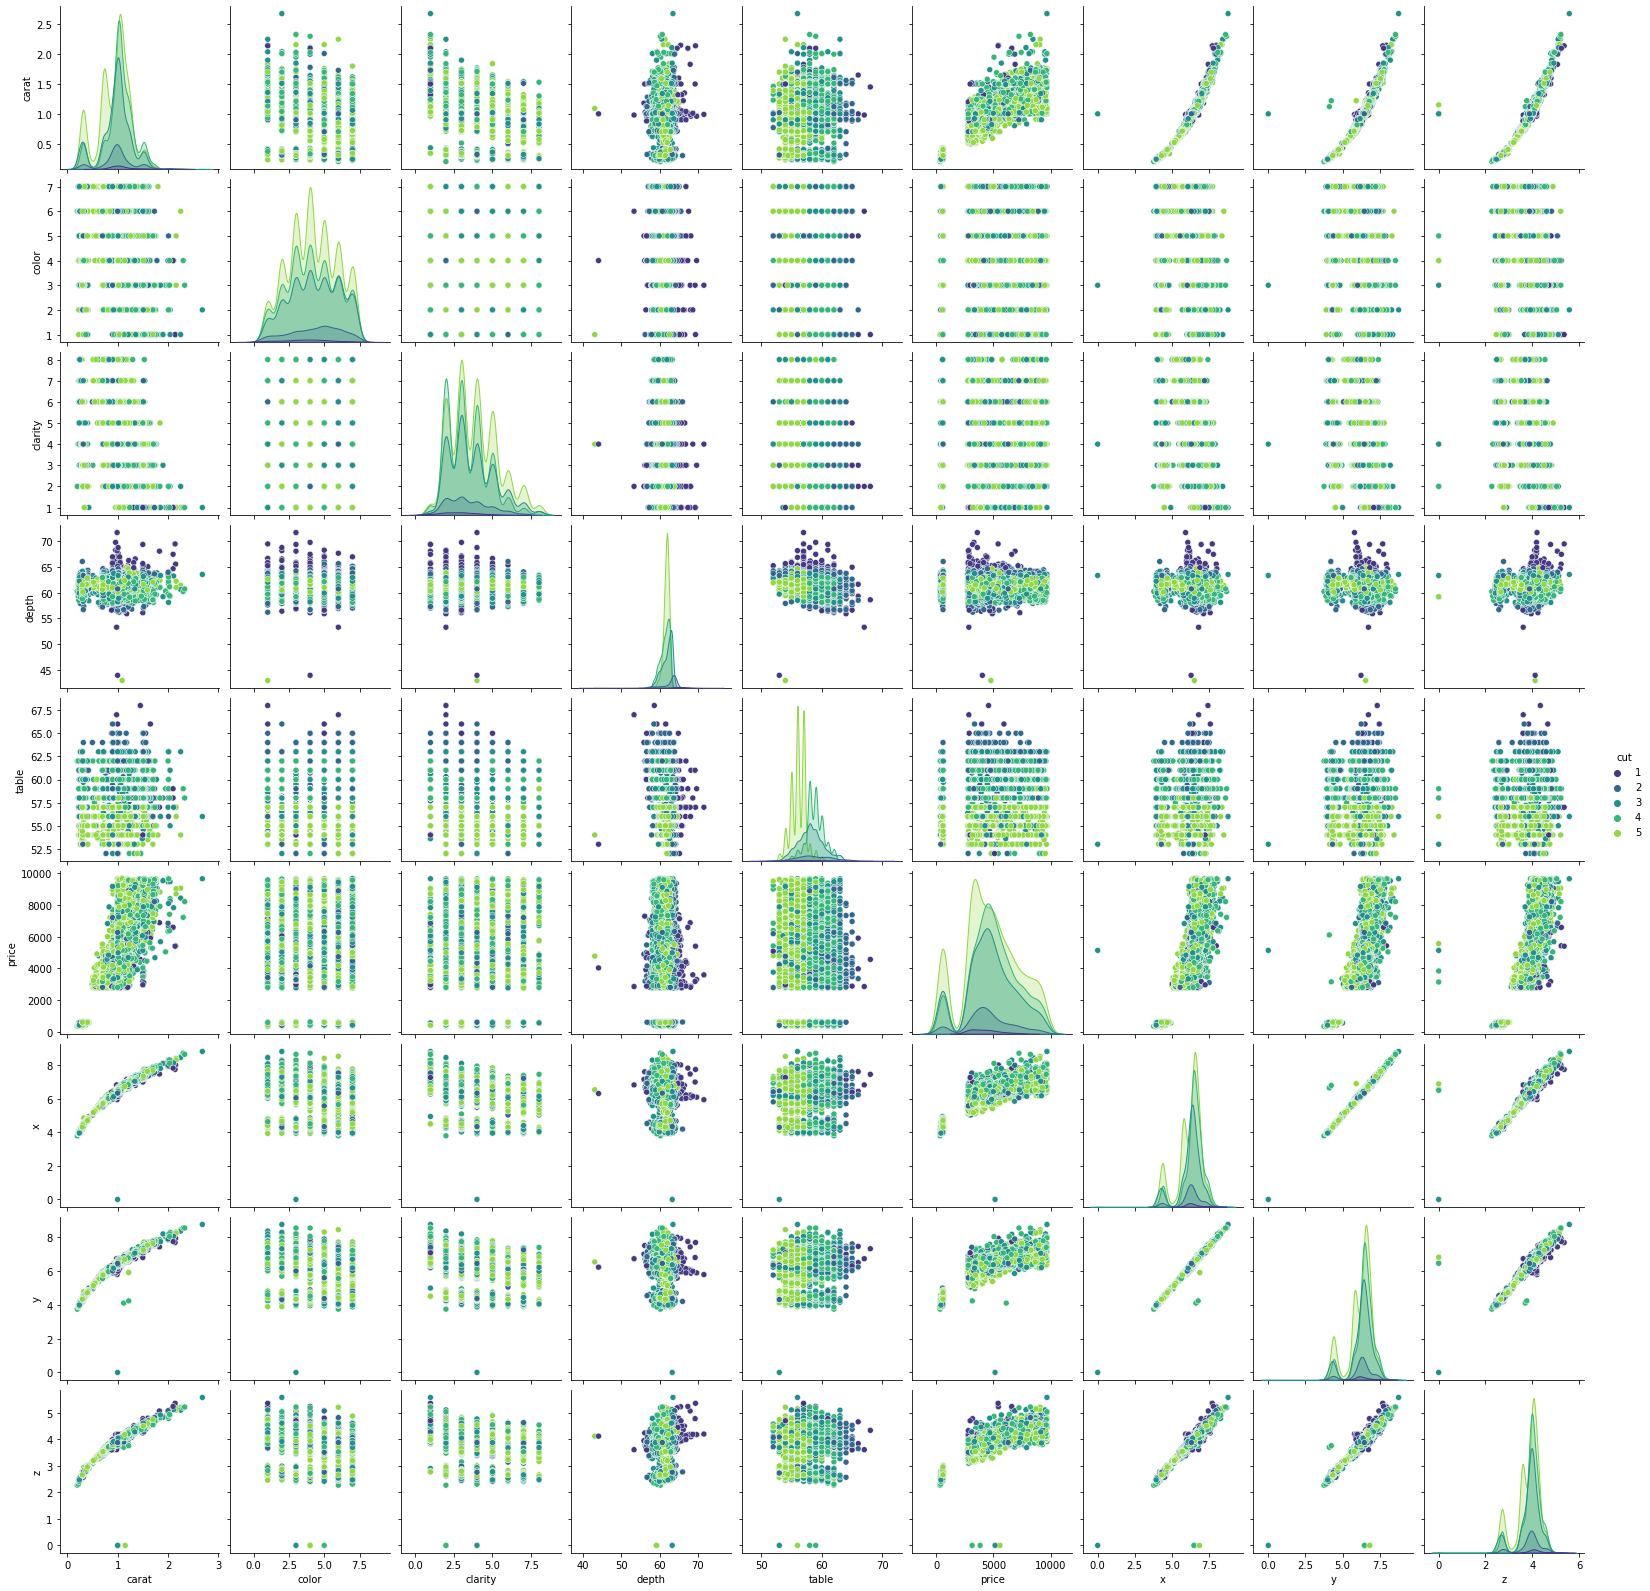

In [12]:
# lets look at the relation between price range and the other features
# 25_000 obs in the dataset takes a long time to pairplot especially with hue, lets take a sample
# and lets weight the sample to have an accurate representation of our classes into our graph
df_sample = df.sample(10_000, weights=df.groupby('cut')['cut'].transform('count'))
palette = sns.color_palette('viridis', df.cut.unique().shape[0])

sns.pairplot(df_sample, hue='cut', palette=palette);

We can see we have a few outliers on the x, y, z scale (which are measurment of the diamonds), so 4-5 diamonds are really small compared to others. They seem to ave a lower price as well, which make sense. 
Lets take a closer look.

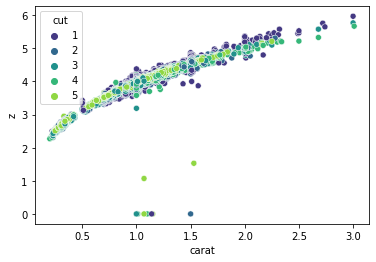

In [13]:
sns.scatterplot(x='carat', y='z', hue='cut', data=df, palette=palette);

In [14]:
# some of their measurment is actually 0, which is completely incorrect. 
# Lets remove them
df.loc[df.z<2]
df.drop(df.loc[df.z<2].index, inplace=True)

In [15]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z,Timestamp
0,0.23,5,6,2,61.5,55.0,326,3.95,3.98,2.43,1960-01-01
1,0.21,4,6,3,59.8,61.0,326,3.89,3.84,2.31,1960-01-02
2,0.23,2,6,5,56.9,65.0,327,4.05,4.07,2.31,1960-01-03
3,0.29,4,2,4,62.4,58.0,334,4.20,4.23,2.63,1960-01-04
4,0.31,2,1,2,63.3,58.0,335,4.34,4.35,2.75,1960-01-05
...,...,...,...,...,...,...,...,...,...,...,...
21572,1.44,2,4,5,63.6,58.0,9677,7.01,6.96,4.44,2019-01-23
21573,1.51,1,3,4,57.4,61.0,9678,7.49,7.63,4.34,2019-01-24
21574,1.06,3,6,6,63.4,55.0,9680,6.46,6.51,4.11,2019-01-25
21575,1.07,3,7,5,59.9,55.0,9681,6.69,6.71,4.01,2019-01-26


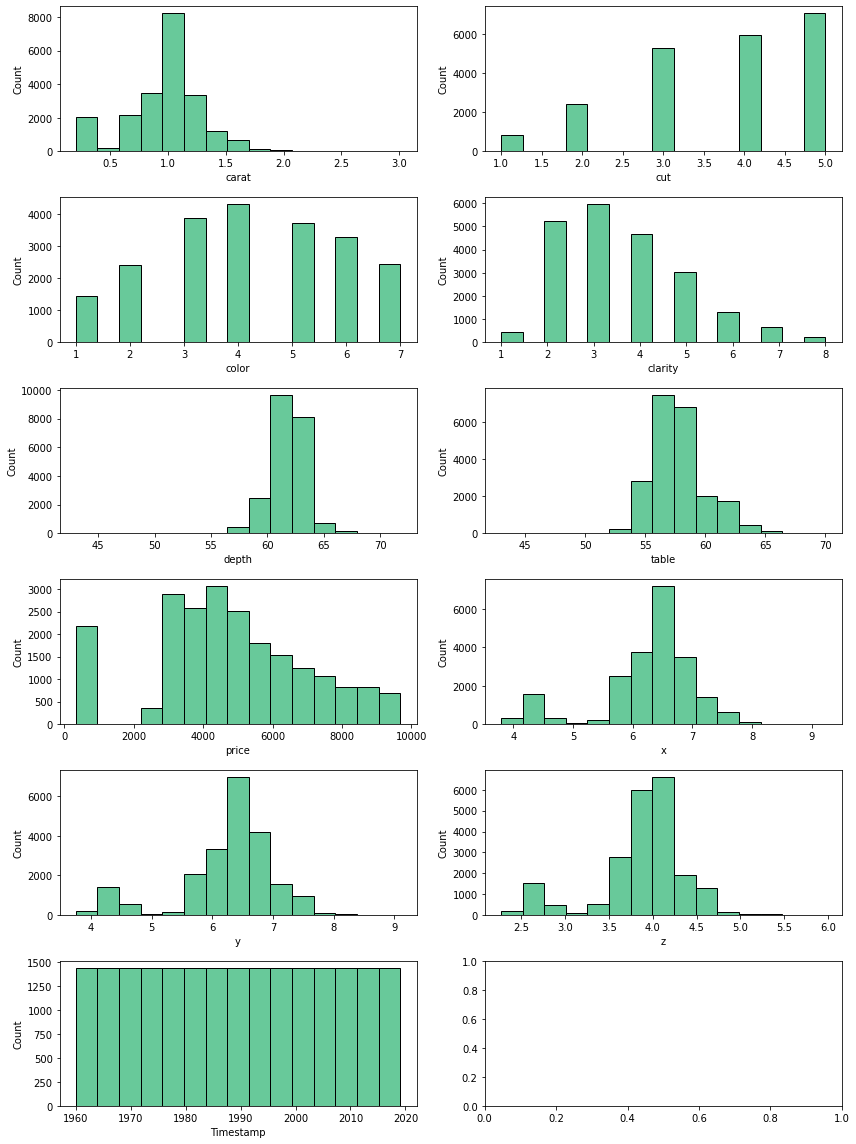

In [16]:
# Lets check the distribution of our var
cols = df.columns.to_list()

fig,axes = plt.subplots(nrows=6,ncols=2,figsize=(12,4*4))

for col, ax in zip(cols, axes.ravel()):
    sns.histplot(x= df[col], bins=15, ax=ax, color=palette[3])

plt.tight_layout()

In [17]:
# some of our features seem skewed, lets check that
skewed_feats = pd.DataFrame(df.skew(),columns=['skewness'])
skewed = skewed_feats.loc[skewed_feats.skewness>= 0.7]

print(f'We have {skewed.shape[0]} feat that are skewed:')
skewed

# its barely skewed, no need to transform it

We have 1 feat that are skewed:


C:\Users\xavier\AppData\Local\Temp\ipykernel_8620\3974241854.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skewed_feats = pd.DataFrame(df.skew(),columns=['skewness'])


,skewness
clarity,0.708606


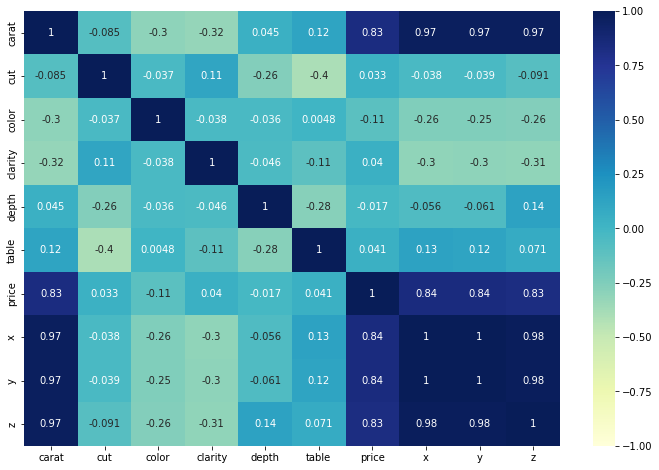

In [18]:
correlations = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, vmin=-1, vmax=1, cmap="YlGnBu")
plt.show();

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

import optuna

import warnings
warnings.filterwarnings("ignore")

C:\Users\xavier\anaconda3\envs\env_X\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
X, y = df.drop(['cut', 'Timestamp'], axis=1).values, df.cut.values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

print(f'shape of our train dataset is: {X_tr.shape} with train target {y_tr.shape}')
print(f'shape of our test dataset is: {X_te.shape} with test target {y_te.shape}')

shape of our train dataset is: (15096, 9) with train target (15096,)
shape of our test dataset is: (6470, 9) with test target (6470,)


In [21]:
# fine tuned model:
model_lgb = lgb.LGBMClassifier(objective='multiclass',
                               n_estimators= 620,
                               learning_rate=0.017475148203262847,
                               num_leaves= 73,
                               min_data_in_leaf = 19,
                               bagging_fraction= 0.76,
                               bagging_freq= 1,
                               feature_fraction= 0.8600000000000001,
                              feature_fraction_seed=14, bagging_seed=14)

# Create Pipeline
pipe_lgb = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', model_lgb)
])

pipe_lgb.fit(X_tr, y_tr)

print(f'score: {pipe_lgb.score(X_te, y_te)}')

[LightGBM] [Warning] feature_fraction is set=0.8600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8600000000000001
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] bagging_fraction is set=0.76, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
score: 0.784080370942813


In [22]:
# lets tune it quickly to have a better score

In [23]:
# use optuna to tune hyperparams

def objective(trial):
    
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 700, step=20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "num_leaves": trial.suggest_int("num_leaves", 2, 100, step=1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 30, step=1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.01),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.01),
    }

    # Create Pipeline
    pipe_lgb = Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', lgb.LGBMClassifier(**param_grid, objective='multiclass', feature_fraction_seed=14, bagging_seed=14))
    ])

    pipe_lgb.fit(X_tr, y_tr)
    score = pipe_lgb.score(X_te, y_te)
    # print(f"Model score: {score:%}")
    return score

# study = optuna.create_study(direction="maximize",
#     sampler=optuna.samplers.TPESampler(), study_name='LGBM optimizer'
# );
# study.optimize(objective, n_trials=30);

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


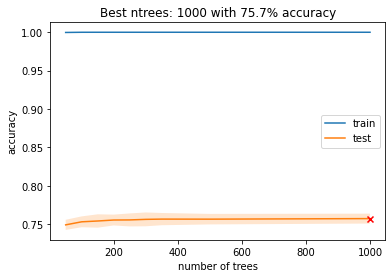

Test accuracy random forest model: 76.38%


In [24]:
# Create a RandomForest pipeline

rf_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=14))
])
grid = {
    'rf__n_estimators':[50, 100, 150, 200, 250, 300, 350, 500, 1000],
        }

grid_rf = GridSearchCV(rf_pipe, grid, cv=5, return_train_score=True, verbose=2, n_jobs=-1)
# Fit estimator
grid_rf.fit(X_tr, y_tr)

# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_rf.cv_results_)
# Group results by alpha value
grouped = cv_results.groupby('param_rf__n_estimators').mean()
# Plot mean scores
plt.plot(grouped.index, grouped.mean_train_score, label='train')
plt.plot(grouped.index, grouped.mean_test_score, label='test')
# Add marker for best score
best_ntree = grouped.mean_test_score.idxmax()
plt.scatter(best_ntree, grouped.mean_test_score.max(), marker='x', c='red', zorder=10)
# Quantify variance with ±std curves
plt.fill_between(grouped.index, grouped.mean_train_score-grouped.std_train_score, grouped.mean_train_score+grouped.std_train_score, alpha=0.2)
plt.fill_between(grouped.index, grouped.mean_test_score-grouped.std_test_score, grouped.mean_test_score+grouped.std_test_score, alpha=0.2)
plt.title('Best ntrees: {} with {:.1f}% accuracy'.format(best_ntree, 100*grouped.mean_test_score[best_ntree]))
plt.ylabel('accuracy')
plt.xlabel('number of trees')
plt.legend()
plt.show()

print('Test accuracy random forest model: {:.2f}%'.format(100*grid_rf.score(X_te, y_te)))

In [28]:
# I have created 2 models and tuned them in different way, simply because as its an assesment for a position, I want to 
# demonstrate that I know several tools.

# I will take the light gbm, althought the rf score was calculated with gridsearch (so was averaged over
# a 5 foldings so it might be more robust, the light gb model had better predictions.

# save model
with open('model_lgbm.pkl','wb') as f:
    pickle.dump(pipe_lgb,f)
    
df.reset_index(drop=True, inplace=True)
df.to_csv("training_df.csv", encoding = 'utf-8', index=False)